In [1]:
!pip install caer canaro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.5/809.5 kB 13.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 96.7 MB/s eta 0:00:00:00:0100:01


In [93]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc

In [94]:
IMG_SIZE = (80,80)
channels = 1
char_path = r'/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset'

In [95]:
char_dict = {}   # Create an empty dictionary to store character counts

for char in os.listdir(char_path):   # Loop through each folder name in the given path
    # Count the number of files in each folder and save it in the dictionary
    char_dict[char] = len(os.listdir(os.path.join(char_path, char)))

# Sort the dictionary by value in descending order using caer's sort_dict function
char_dict = caer.sort_dict(char_dict, descending=True)

char_dict  # Display the sorted dictionary


[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [96]:
characters = []       # Create an empty list to store characters
count = 0             # Set a counter to 0

for i in char_dict:   # Loop through each item in the dictionary 'char_dict'
    characters.append(i[0])   # Add the first character of the key to the list
    count += 1                # Increase the counter by 1
    if count >= 10:           # If 10 characters are added, stop the loop
        break

characters            # Show the final list of characters


['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [97]:
# Create the training data
train = caer.preprocess_from_dir(         # Use caer's function to load and preprocess image data
            char_path,                    # Path where all the character folders are located
            characters,                   # List of top characters you want to include
            channels=channels,            # Number of color channels (1 for grayscale, 3 for RGB)
            IMG_SIZE=IMG_SIZE,            # Resize all images to this size (e.g., (64, 64))
            isShuffle=True                # Shuffle the data randomly to avoid bias
        )


[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 1.8219921588897705s
[INFO] At 1000 files
[INFO] 1454 files found in 1.692164421081543s
[INFO] At 1000 files
[INFO] 1452 files found in 1.6466410160064697s
[INFO] At 1000 files
[INFO] 1354 files found in 1.6794729232788086s
[INFO] At 1000 files
[INFO] 1342 files found in 1.6894187927246094s
[INFO] At 1000 files
[INFO] 1291 files found in 1.6399362087249756s
[INFO] At 1000 files
[INFO] 1206 files found in 1.4336984157562256s
[INFO] At 1000 files
[INFO] 1194 files found in 1.598247766494751s
[INFO] At 1000 files
[INFO] 1193 files found in 1.5841786861419678s
[INFO] At 1000 files
[INFO] 1079 files found in 1.5570225715637207s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 0m 50s


In [100]:
len(train)

13811

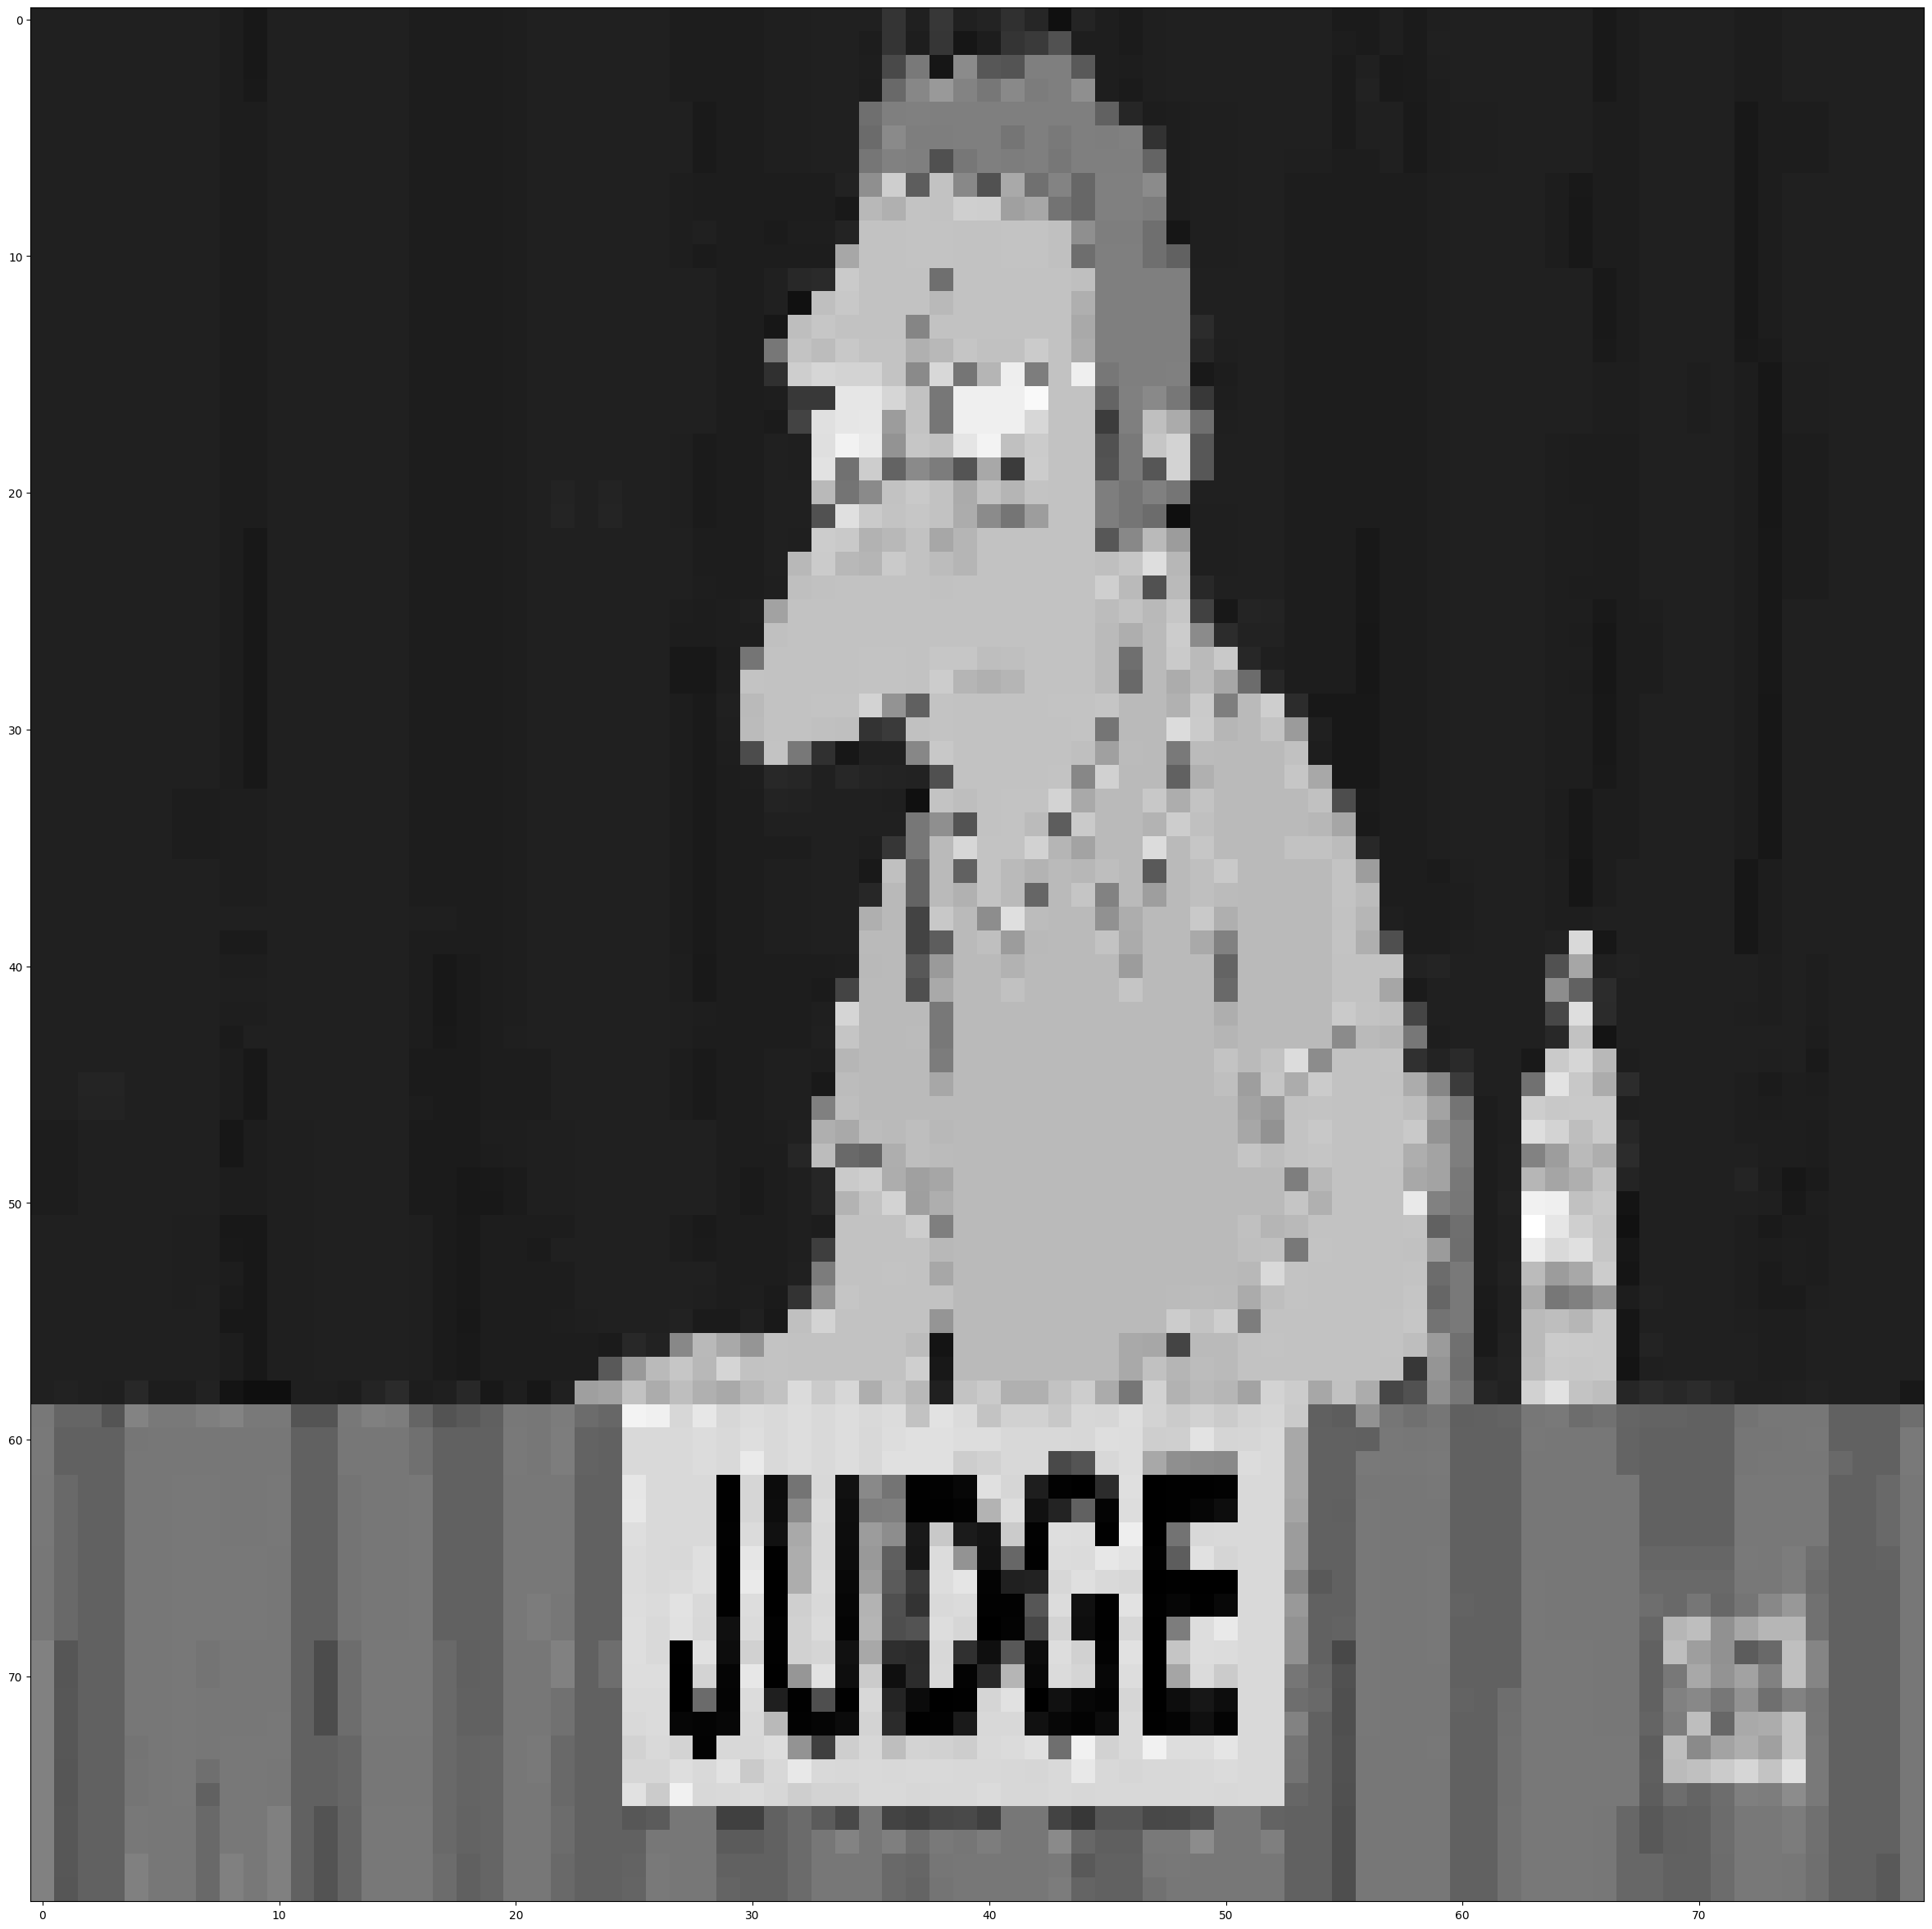

In [101]:
import matplotlib.pyplot as plt    # Import the matplotlib library for plotting

plt.figure(figsize=(30,30))       # Create a big figure window (30x30 inches)

plt.imshow(train[0][0], cmap='gray')  # Show the first image in the training data in grayscale

plt.show()                         # Display the image on the screen


In [102]:
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)
# Separates the training data into two parts:
# - featureSet: the image data (X values)
# - labels: the corresponding class labels (Y values)
# It also resizes the images to IMG_SIZE if needed


In [103]:
from tensorflow.keras.utils import to_categorical
# normalize the featureset ==> (0,1)
featureSet = caer.normalize(featureSet)
labels = to_categorical(labels, len(characters))

In [104]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels,val_ratio=.2)

In [105]:
del train
del featureSet
del labels
gc.collect()

0

In [170]:
BATCH_SIZE = 32
EPOCHS = 15

In [171]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD

# Patch function to replace Canaro's broken version
def fixed_createSimpsonsModel(IMG_SIZE, channels=1, output_dim=10, loss='binary_crossentropy',
                               weight_decay=1e-6, learning_rate=0.001, momentum=0.9, nesterov=True):
    model = Sequential()

    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, channels)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim, activation='softmax'))

    optimizer = SGD(
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        momentum=momentum,
        nesterov=nesterov
    )

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model


In [172]:
import canaro

# Monkey-patch the broken function
canaro.models.createSimpsonsModel = fixed_createSimpsonsModel


In [173]:
model = canaro.models.createSimpsonsModel(
    IMG_SIZE,
    channels=channels,
    output_dim=len(characters),
    loss='categorical_crossentropy',  # Changed to categorical_crossentropy
    weight_decay=1e-6,
    learning_rate=0.001,
    momentum=0.9,
    nesterov=True
)

In [174]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)                   │ (None, 78, 78, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 39, 39, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,142,666 (4.36 MB)

 Trainable params: 1,142,666 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [175]:
from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]

In [176]:
print(x_train.shape)
print(y_train.shape)

(11047, 80, 80, 1)
(11047, 10)


In [177]:
training = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=callbacks_list
)


Epoch 1/15
346/346 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1634 - loss: 2.2602 - val_accuracy: 0.2768 - val_loss: 2.0757 - learning_rate: 0.0100
Epoch 2/15
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2875 - loss: 2.0436 - val_accuracy: 0.3506 - val_loss: 1.8723 - learning_rate: 0.0100
Epoch 3/15
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3685 - loss: 1.8478 - val_accuracy: 0.4418 - val_loss: 1.6486 - learning_rate: 0.0100
Epoch 4/15
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4556 - loss: 1.6088 - val_accuracy: 0.5318 - val_loss: 1.4510 - learning_rate: 0.0100
Epoch 5/15
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5422 - loss: 1.3817 - val_accuracy: 0.5821 - val_loss: 1.2989 - learning_rate: 0.0100
Epoch 6/15
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6148 - loss: 1.1685 - val_accuracy: 0.6302 - val_loss: 1.1714 - learning_rate: 0.0100
Epoch 7/15
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6690 - loss: 0.9801 -

In [116]:
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

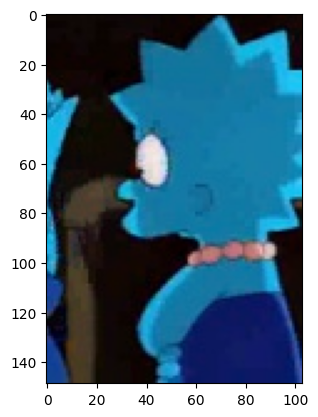

In [199]:
test_path = r'/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/lisa_simpson_13.jpg'
img = cv.imread(test_path)
plt.imshow(img,)
plt.show()

In [200]:
def prepare(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.resize(img, IMG_SIZE)
    img=caer.reshape(img, IMG_SIZE,1)
    return img

In [201]:
predictions = model.predict(prepare(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [202]:
predictions

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [203]:
print(characters[np.argmax(predictions[0])])

lisa_simpson
